In [26]:
import cv2
import os
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix 
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
with open("non_violence_v_path.pkl","rb") as f:
    non_violence_path_list=pickle.load(f)
with open("violence_v_path.pkl","rb") as f:
    violence_path_list=pickle.load(f)

In [3]:
print(len(non_violence_path_list))
print(len(violence_path_list))

1000
1000


In [4]:
# labels violence as 1 and non violence as 0
label=[0]*1000+[1]*1000
print(len(label))

2000


In [5]:
path_list=non_violence_path_list+violence_path_list
print(len(path_list))

2000


In [6]:
xtrain,xtest,ytrain,ytest=train_test_split(path_list,label,test_size=0.20,shuffle=True,stratify=label,random_state=42)
print(len(xtrain))
print(len(ytrain))
print(len(xtest))
print(len(ytest))

1600
1600
400
400


In [7]:
print(xtrain[0:3])
print(ytrain[0:3])

[['C:\\Users\\MUNDI\\ML\\violence_dataset\\0_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\1_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\2_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\3_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\4_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\5_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\6_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\7_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\8_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\9_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\10_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\11_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\12_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\13_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\14_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\15_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset\\16_V_529.jpeg', 'C:\\Users\\MUNDI\\ML\\violence_dataset

In [8]:
class batchGenerator(keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = []

        for video_paths in self.x[idx * self.batch_size:(idx + 1) * self.batch_size]:
            video_frames=[]
            for path in video_paths:
                frame=cv2.imread(path)
                frame=cv2.resize(frame,(64,64))
                video_frames.append(frame)
                
            video_frames=(np.array(video_frames)/255.0)    
            batch_x.append(video_frames)

        batch_x = np.array(batch_x)
        batch_x = batch_x.astype('float32')
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x),np.array(batch_y).astype('uint8').reshape((-1,1))

In [9]:
img_size=64
self_model=models.Sequential()
self_model.add( layers.InputLayer(input_shape=(20,img_size,img_size,3)) )
self_model.add(TimeDistributed(layers.Conv2D( 32,(3,3),activation='relu',padding='same',input_shape=(img_size,img_size,3) )))
self_model.add(TimeDistributed(layers.MaxPooling2D(4,4)))
self_model.add(TimeDistributed(layers.Dropout(.25)))

self_model.add(TimeDistributed(layers.Conv2D(64,(3,3),activation='relu',padding='same')))
self_model.add(TimeDistributed(layers.MaxPooling2D(4,4)))
self_model.add(TimeDistributed(layers.Dropout(.25)))

self_model.add(TimeDistributed(layers.Conv2D(128,(3,3),activation='relu',padding='same')))
self_model.add(TimeDistributed(layers.MaxPooling2D(2,2)))
self_model.add(TimeDistributed(layers.Dropout(.25)))

#self_model.add(TimeDistributed(layers.Conv2D(512,(3,3),activation='relu',padding='same')))
#self_model.add(TimeDistributed(layers.MaxPooling2D(2,2)))


self_model.add(TimeDistributed(layers.Flatten()))
self_model.add(layers.LSTM(200))
self_model.add(layers.Dropout(.25))

self_model.add(layers.Dense(100,activation="relu"))
self_model.add(layers.Dense(1,activation="sigmoid"))
self_model.build()

In [10]:
self_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 64)     0

In [11]:
self_model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

history=self_model.fit(batchGenerator(xtrain,ytrain,32),epochs=35,validation_data=batchGenerator(xtest,ytest,32))

Epoch 1/35
50/50 [==============================] - 817s 16s/step - loss: 0.6946 - accuracy: 0.5263 - val_loss: 0.6726 - val_accuracy: 0.7350
Epoch 2/35
50/50 [==============================] - 251s 5s/step - loss: 0.6597 - accuracy: 0.6194 - val_loss: 0.6808 - val_accuracy: 0.5325
Epoch 3/35
50/50 [==============================] - 50s 1s/step - loss: 0.6005 - accuracy: 0.6525 - val_loss: 0.4821 - val_accuracy: 0.7800
Epoch 4/35
50/50 [==============================] - 54s 1s/step - loss: 0.5071 - accuracy: 0.7644 - val_loss: 0.4477 - val_accuracy: 0.7975
Epoch 5/35
50/50 [==============================] - 65s 1s/step - loss: 0.4724 - accuracy: 0.7800 - val_loss: 0.5331 - val_accuracy: 0.7150
Epoch 6/35
50/50 [==============================] - 242s 5s/step - loss: 0.3778 - accuracy: 0.8256 - val_loss: 0.3361 - val_accuracy: 0.8600
Epoch 7/35
50/50 [==============================] - 82s 2s/step - loss: 0.3302 - accuracy: 0.8625 - val_loss: 0.3403 - val_accuracy: 0.8700
Epoch 8/35
50/50

In [12]:
self_model.save('model.h5')

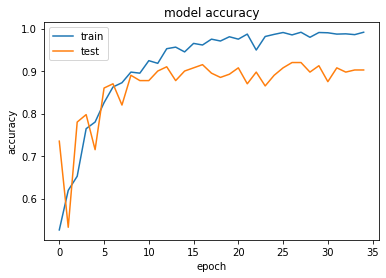

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

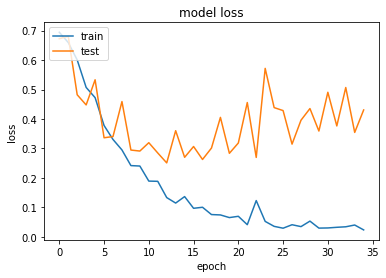

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
predictions=self_model.predict(batchGenerator(xtest,ytest,32),batch_size=32)

In [23]:
predictions=(predictions>0.5).astype(int)
predictions

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
    

In [24]:
confusion_matrix(ytest,predictions)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[179,  21],
       [ 18, 182]])>

In [27]:
precision, recall, fscore, support = score(ytest,predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90862944 0.89655172]
recall: [0.895 0.91 ]
fscore: [0.90176322 0.90322581]
support: [200 200]
